# Import and Read Data

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import gpboost as gpb
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn import metrics, model_selection
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve, auc, 
                             ConfusionMatrixDisplay, mean_squared_error)
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, GroupKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
filepaths = {
    "original_data": "../Data/original_data.csv",
    "original_no_overdose_data": "../Data/original_no_overdose_data.csv",
    "original_overdose_data": "../Data/original_overdose_data.csv"
}

# Define bins and labels outside the loop, as they remain constant
bins = [12, 21, 35, 50, float('inf')]  # The last bin captures 50 and above
labels = [1, 2, 3, 4]

for key, path in filepaths.items():
    data = pd.read_csv(path, dtype=object)
    
    data['Residence_State'] = data['Residence_State(FIPS)']
    data.drop('Residence_State(FIPS)', axis=1, inplace=True)
    data['Residence_County'] = data['Residence_County(FIPS)']
    data.drop('Residence_County(FIPS)', axis=1, inplace=True)
    
    
    data['Residence_State_And_County'] = data['Residence_State'] + ", " + data['Residence_County']
    data.drop(['Residence_State', 'Residence_County'], axis=1, inplace=True)

    # Process The_Decedent_Age column
    data['The_Decedent_Age'] = data['The_Decedent_Age'].astype(str).str[1:].astype(int)  # Remove leading '1' and convert to int
    data['The_Decedent_Age_Group'] = pd.cut(data['The_Decedent_Age'], bins=bins, labels=labels, right=False)
    data.drop(columns=['The_Decedent_Age'], inplace=True)  # Drop the original age column
    
    globals()[key] = data

# Split Data to train, and test

In [3]:
def data_split_and_label(data_set, label_value):
    """Splits the data into train and test sets and adds a label."""
    train, test = model_selection.train_test_split(data_set, test_size=0.3)
    train.insert(0, "y_value", label_value)
    test.insert(0, "y_value", label_value)
    return train, test

# Splitting data and adding labels
train_class_0, test_class_0 = data_split_and_label(original_no_overdose_data, 0)
train_class_1, test_class_1 = data_split_and_label(original_overdose_data, 1)

# Resampling the non-overdose data
num_of_samples = len(train_class_1)
train_class_0_resampled = [train_class_0.sample(num_of_samples) for _ in range(1)]
test_class_0_resampled = [test_class_0.sample(int(3*num_of_samples/7)) for _ in range(1)]

# Combining and shuffling
arrayoftrain = [(pd.concat([train_0, train_class_1])).sample(frac=1) for train_0 in train_class_0_resampled]
arrayoftest = [(pd.concat([test_0, test_class_1])).sample(frac=1) for test_0 in test_class_0_resampled]

# Group by Race and others

In [4]:
def process_data(array_of_data, columns_to_drop):
    x_data = []
    y_data = []
    
    for data in array_of_data:
        data_x = data.drop(columns=columns_to_drop).sample(n=len(data))
        data_y = data_x.pop("y_value").astype(bool)
        x_data.append(data_x)
        y_data.append(data_y)
        
    return x_data, y_data

# Define columns to drop
columns_to_drop = ["General_Place_of_death_and_decedents_status", 
                   "The_Decedent_State_or_country_of_birth",
                   "Occurrence_County_Population_size", 
                   "Occurrence_County(FIPS)",
                   "Occurrence_State(FIPS)",
                   "General_Day_of_week_of_death", 
                   "General_Record_Type",
                   "General_Resident_status",
                   "General_Manner_of_death", 
                   "The_Decedent_Date_of_Death",
                   "Underlying_Cause_ICD-10_code",
                   "The_Decedent_Race_Recode_5", 
                   "The_Decedent_Hispanic_Origin/Race_Recode"]


# Process main data
arrayoftrain_x, arrayoftrain_y = process_data(arrayoftrain, columns_to_drop)
arrayoftest_x, arrayoftest_y = process_data(arrayoftest, columns_to_drop)


# # Using dictionaries to process data by group
# grouped_data_keys = ['white', 'black', 'AmericanIndian', 'asian', 'hispanic', 'male', 'female', 'Metropolitan', 'Nonmetropolitan', 'Foreignresidents']
# grouped_data = {key: [] for key in grouped_data_keys}

# grouped_columns = {
#     'white': 'The_Decedent_Race',
#     'black': 'The_Decedent_Race',
#     'AmericanIndian': 'The_Decedent_Race',
#     'asian': 'The_Decedent_Race',
#     'hispanic': 'The_Decedent_Race',
#     'male': 'The_Decedent_Sex',
#     'female': 'The_Decedent_Sex',
#     'Metropolitan': 'Residence_Met_or_Nonmet_county',
#     'Nonmetropolitan': 'Residence_Met_or_Nonmet_county',
#     'Foreignresidents': 'Residence_Met_or_Nonmet_county'
# }

# grouped_values = {
#     'white': '1',
#     'black': '2',
#     'AmericanIndian': '3',
#     'asian': '4',
#     'hispanic': '6',
#     'male': 'M',
#     'female': 'F',
#     'Metropolitan': '1',
#     'Nonmetropolitan': '2',
#     'Foreignresidents': 'Z'
# }

# for key in grouped_data_keys:
#     grouped = arrayoftest[0].groupby(grouped_columns[key])
#     grouped_data[key].append(grouped.get_group(grouped_values[key]))


# # Process grouped data
# grouped_data_x, grouped_data_y = {}, {}
# for key in grouped_data_keys:
#     x, y = process_data(grouped_data[key], columns_to_drop)
#     grouped_data_x[key] = x
#     grouped_data_y[key] = y


# FixEffect

# FixEffect for XGBOOST

In [7]:
# Define X and y
X, y = arrayoftrain_x[0], arrayoftrain_y[0]

# Convert 'object' dtype columns to categorical type
categorical_columns = ['Residence_Met_or_Nonmet_county', 'The_Decedent_Sex', 'The_Decedent_Race', 'Residence_State_And_County', 'The_Decedent_Marital_status', 'The_Decedent_Education']

for col in categorical_columns:
    X[col] = X[col].astype('category')

# Convert columns which are numerical but represented as 'object' to their respective types
numerical_as_object = ['General_Data_year', 'The_Decedent_Age_Group']
for col in numerical_as_object:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Define the model and parameters
params = {
    'learning_rate': [0.07],
    'max_depth': [7],
    'n_estimators': [150],
    'colsample_bytree': [0.7],
    'subsample': [0.9],
    'gamma': [0.4],
    'reg_alpha': [0.005],
    'reg_lambda': [0.3],
    'tree_method': ['gpu_hist'],
    'enable_categorical': [True]
}

model = xgb.XGBClassifier()

# Outer CV for model evaluation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)  # Using StratifiedKFold for balanced splits

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner CV for hyperparameter tuning
    inner_cv = KFold(n_splits=5, shuffle=True)
    grid_search = GridSearchCV(model, param_grid=params, cv=inner_cv, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Getting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Output the best parameters for each fold
    print(f'Best parameters for fold {i + 1}: {best_params}')
    
    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    
    # Getting metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    
    # Printing metrics for each fold
    print(f"Fold {i + 1}:")
    print(f'True Positives (TP): {tp}')
    print(f'False Positives (FP): {fp}')
    print(f'True Negatives (TN): {tn}')
    print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability

Best parameters for fold 1: {'colsample_bytree': 0.7, 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Fold 1:
True Positives (TP): 59829
False Positives (FP): 13276
True Negatives (TN): 62043
False Negatives (FN): 15490
Accuracy: 0.8090
Precision: 0.8184
Recall: 0.7943
F1 Score: 0.8062
AUC-ROC: 0.8837
--------------------------------------------------
Best parameters for fold 2: {'colsample_bytree': 0.7, 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Fold 2:
True Positives (TP): 59715
False Positives (FP): 13484
True Negatives (TN): 61835
False Negatives (FN): 15604
Accuracy: 0.8069
Precision: 0.8158
Recall: 0.7928
F1 Score: 0.8041
AUC-ROC: 0.8816
--------------------------------------------------
Best parameters 

In [8]:
def train_and_evaluate_xgb_model(train_x, train_y, test_x, test_y):
    """Train and evaluate an XGBoost model."""
    
    # Define hyperparameters
    params = {
        'learning_rate': 0.07,
        'max_depth': 7,
        'n_estimators': 150,
        'subsample': 0.9,
        'colsample_bytree': 0.6,
        'gamma': 0.4,
        'reg_alpha': 0.005,
        'reg_lambda': 0.3,
        'objective': 'binary:logistic',
        'seed': 40,
        'tree_method': 'gpu_hist',
        'enable_categorical': True
    }

    # Initialize and train the XGBoost model
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(train_x, train_y)

    # Predict on the test data
    y_pred = xgb_model.predict(test_x)
    
    # Compute the confusion matrix values
    tn, fp, fn, tp = metrics.confusion_matrix(test_y, y_pred).ravel()

    # Compute other metrics
    accuracy = metrics.accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred)
    recall = recall_score(test_y, y_pred)
    f1 = metrics.f1_score(test_y, y_pred)
    fpr, tpr, _ = roc_curve(test_y, y_pred)
    roc_auc = auc(fpr, tpr)

    # Display results
    print(f'True Positives (TP): {tp}')
    print(f'False Positives (FP): {fp}')
    print(f'True Negatives (TN): {tn}')
    print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
#     # Display feature importances
#     plt.figure(figsize=(6, 6))
#     sorted_idx = xgb_model.feature_importances_.argsort()
#     plt.barh(train_x.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
#     plt.xlabel("XGBoost Feature Importance")
#     plt.show()
    print('-' * 50)  # printing a separator for better readability

#     # Display accuracy
#     accuracy = metrics.accuracy_score(test_y, y_pred)
#     print(f"Accuracy: {accuracy * 100:.2f}%")

#     # Display confusion matrix
#     ConfusionMatrixDisplay.from_estimator(xgb_model, test_x, test_y).plot()
#     plt.title('Confusion Matrix')
#     plt.show()

#     # Display ROC curve
#     fpr, tpr, _ = roc_curve(test_y, y_pred)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, 'k--', label=f'ROC (area = {roc_auc:.2f})', lw=2)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend(loc='lower right')
#     plt.title('ROC Curve')
#     plt.show()

#     # Display precision and recall
#     print(f"Precision Score: {precision_score(test_y, y_pred, average='macro'):.2f}")
#     print(f"Recall Score: {recall_score(test_y, y_pred, average='macro'):.2f}")


    # Return the trained model
    return xgb_model

def preprocess_dataframe(df):
    # Convert categorical columns to 'category' dtype
    categorical_cols = ['Residence_Met_or_Nonmet_county', 'The_Decedent_Sex', 'The_Decedent_Race', 'Residence_State_And_County', 'The_Decedent_Marital_status', 'The_Decedent_Education']
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    # Convert numerical columns stored as strings to 'int' or 'float'
    numeric_cols = ['General_Data_year', 'The_Decedent_Age_Group']
    for col in numeric_cols:
        df[col] = df[col].astype(int)  # or float, if needed

    return df

# Apply preprocessing to all datasets
arrayoftrain_x = [preprocess_dataframe(df) for df in arrayoftrain_x]
arrayoftest_x = [preprocess_dataframe(df) for df in arrayoftest_x]



train_x, train_y = arrayoftrain_x[0], arrayoftrain_y[0]
test_x, test_y = arrayoftest_x[0], arrayoftest_y[0]

myModel = train_and_evaluate_xgb_model(train_x, train_y, test_x, test_y)


True Positives (TP): 121134
False Positives (FP): 25184
True Negatives (TN): 136213
False Negatives (FN): 40264
Accuracy: 0.7972
Precision: 0.8279
Recall: 0.7505
F1 Score: 0.7873
AUC-ROC: 0.7972
--------------------------------------------------


In [8]:
def evaluate_by_features_xgb_model(train_x, train_y, test_x, test_y):
    features_to_evaluate = [
        'The_Decedent_Race', 
        'The_Decedent_Sex', 
        'The_Decedent_Age_Group', 
        'The_Decedent_Marital_status', 
        'The_Decedent_Education',
        'Residence_Met_or_Nonmet_county'
    ]

    for feature in features_to_evaluate:
        print(f"Evaluating based on {feature}...")
        
        unique_values = test_x[feature].unique()

        for value in unique_values:
            # Subset data for the specific feature value
            subset_test_x = test_x[test_x[feature] == value]
            subset_test_y = test_y[test_x[feature] == value]
            
            print(f"Performance for {feature} = {value}")
            
            # Evaluate the performance on the subset
            performance = train_and_evaluate_xgb_model(train_x, train_y, subset_test_x, subset_test_y)

            #print(f"Performance for {feature} = {value}: {performance}")
            

evaluate_by_features_xgb_model(train_x, train_y, test_x, test_y)


Evaluating based on The_Decedent_Race...
Performance for The_Decedent_Race = 1
True Positives (TP): 94828
False Positives (FP): 17736
True Negatives (TN): 109448
False Negatives (FN): 31709
Accuracy: 0.8051
Precision: 0.8424
Recall: 0.7494
F1 Score: 0.7932
AUC-ROC: 0.8050
--------------------------------------------------
Performance for The_Decedent_Race = 6
True Positives (TP): 10990
False Positives (FP): 2588
True Negatives (TN): 8021
False Negatives (FN): 2383
Accuracy: 0.7927
Precision: 0.8094
Recall: 0.8218
F1 Score: 0.8156
AUC-ROC: 0.7889
--------------------------------------------------
Performance for The_Decedent_Race = 3
True Positives (TP): 1434
False Positives (FP): 379
True Negatives (TN): 658
False Negatives (FN): 312
Accuracy: 0.7517
Precision: 0.7910
Recall: 0.8213
F1 Score: 0.8058
AUC-ROC: 0.7279
--------------------------------------------------
Performance for The_Decedent_Race = 2
True Positives (TP): 11737
False Positives (FP): 3948
True Negatives (TN): 14728
Fal

True Positives (TP): 97
False Positives (FP): 41
True Negatives (TN): 50
False Negatives (FN): 23
Accuracy: 0.6967
Precision: 0.7029
Recall: 0.8083
F1 Score: 0.7519
AUC-ROC: 0.6789
--------------------------------------------------


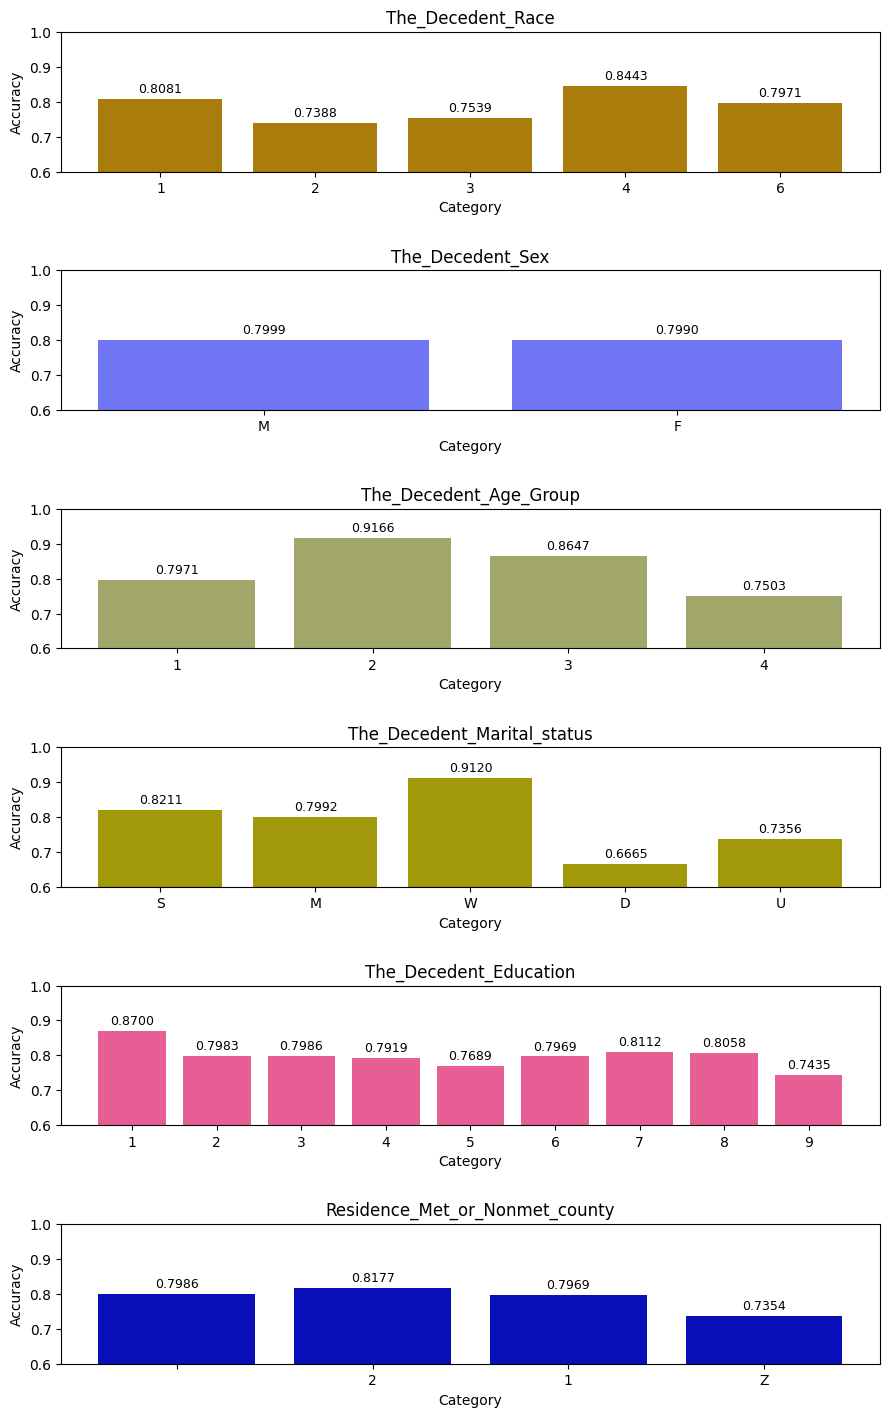

In [9]:
# Defining the data
categories_performance = {
    'The_Decedent_Race': [('1', 0.8081), ('2', 0.7388), ('3', 0.7539), ('4', 0.8443), ('6', 0.7971)],
    'The_Decedent_Sex': [('M', 0.7999), ('F', 0.7990)],
    'The_Decedent_Age_Group': [('1', 0.7971), ('2', 0.9166), ('3', 0.8647), ('4', 0.7503)],
    'The_Decedent_Marital_status': [('S', 0.8211), ('M', 0.7992), ('W', 0.9120), ('D', 0.6665), ('U', 0.7356)],
    'The_Decedent_Education': [('1', 0.8700), ('2', 0.7983), ('3', 0.7986), ('4', 0.7919), ('5', 0.7689),  
                               ('6', 0.7969), ('7', 0.8112), ('8', 0.8058), ('9', 0.7435)],
    'Residence_Met_or_Nonmet_county': [('', 0.7986), ('2', 0.8177), ('1', 0.7969), ('Z', 0.7354)]
}

# Plotting the data
fig, axs = plt.subplots(6, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for ax, (key, values) in zip(axs, categories_performance.items()):
    labels, accuracies = zip(*values)
    ax.bar(labels, accuracies, color=np.random.rand(3,))
    ax.set_ylim([0.6, 1.0])
    ax.set_title(key)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Category')
    for i, v in enumerate(accuracies):
        ax.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=9)

plt.show()

# FixEffect for Linear

In [9]:
# Encode labels
train_x['Label'] = train_y
test_x['Label'] = test_y

combined = pd.concat([train_x, test_x], axis=0)

le_dict = {}

for col in combined.columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    le_dict[col] = le

# Split the datasets back, making sure to work with copies
train_x_encoded = combined.iloc[:len(train_x)].copy()
test_x_encoded = combined.iloc[len(train_x):].copy()

# Fix the dtype of 'Label' column
train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

def run_fixed_effect_model_linear(train_x, train_y, test_x, test_y):
    # Work with local copies
    train_x_copy = train_x.copy()
    test_x_copy = test_x.copy()
    
    # Encode labels
    train_x_copy['Label'] = train_y
    test_x_copy['Label'] = test_y

    combined = pd.concat([train_x_copy, test_x_copy], axis=0)

    le_dict = {}
    for col in combined.columns:
        le = LabelEncoder()
        combined[col] = le.fit_transform(combined[col])
        le_dict[col] = le

    train_x_encoded = combined.iloc[:len(train_x_copy)].copy()
    test_x_encoded = combined.iloc[len(train_x_copy):].copy()

    train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

    formula = 'Label ~ General_Data_year + The_Decedent_Sex + The_Decedent_Age_Group + The_Decedent_Race + Residence_State_And_County + The_Decedent_Marital_status + The_Decedent_Education'

    fixed_effect_model = smf.ols(formula, data=train_x_encoded)
    fixed_effect_model_fit = fixed_effect_model.fit()

    test_df = test_x_encoded.copy()
    test_df['predicted_values'] = fixed_effect_model_fit.predict(test_df)
    test_df['predicted_binary'] = test_df['predicted_values'].apply(lambda x: 1 if x > 0.5 else 0)

    accuracy = accuracy_score(test_df['Label'], test_df['predicted_binary'])
    precision = precision_score(test_df['Label'], test_df['predicted_binary'])
    recall = recall_score(test_df['Label'], test_df['predicted_binary'])
    f1 = f1_score(test_df['Label'], test_df['predicted_binary'])
    roc_auc = roc_auc_score(test_df['Label'], test_df['predicted_values'])
    tn, fp, fn, tp = confusion_matrix(test_df['Label'], test_df['predicted_binary']).ravel()
    
    print(f'True Positives (TP): {tp}')
    print(f'False Positives (FP): {fp}')
    print(f'True Negatives (TN): {tn}')
    print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability
    
    return fixed_effect_model

run_fixed_effect_model_linear(train_x, train_y, test_x, test_y)

True Positives (TP): 105019
False Positives (FP): 14293
True Negatives (TN): 147104
False Negatives (FN): 56379
Accuracy: 0.7811
Precision: 0.8802
Recall: 0.6507
F1 Score: 0.7482
AUC-ROC: 0.8359
--------------------------------------------------


In [ ]:
def evaluate_by_features_linear_model(train_x, train_y, test_x, test_y):
    features_to_evaluate = [
        'The_Decedent_Race', 
        'The_Decedent_Sex', 
        'The_Decedent_Age_Group', 
        'The_Decedent_Marital_status', 
        'The_Decedent_Education',
        'Residence_Met_or_Nonmet_county'
    ]

    for feature in features_to_evaluate:
        print(f"Evaluating based on {feature}...")
        
        unique_values = test_x[feature].unique()

        for value in unique_values:
            # Subset data for the specific feature value
            subset_test_x = test_x[test_x[feature] == value]
            subset_test_y = test_y[test_x[feature] == value]
            
            print(f"Performance for {feature} = {value}")
            
            # Evaluate the performance on the subset
            performance = run_fixed_effect_model_linear(train_x, train_y, subset_test_x, subset_test_y)

            #print(f"Performance for {feature} = {value}: {performance}")


evaluate_by_features_linear_model(train_x, train_y, test_x, test_y)

# MixEffect

## MixEffect for GPBoost

In [15]:
# 1. Prepare the data

# 2. Define the parameter grid for tuning
param_grid = {
    'max_depth': [7],
    'n_estimators': [150],
    'colsample_bytree': [0.7],
    'subsample': [0.9],
    #'gamma': [0.4],
    'reg_alpha': [0.005],
    'reg_lambda': [0.3],
    #'tree_method': ['gpu_hist'],
    #'enable_categorical': [True]
}

# 3. Nested CV for hyperparameter tuning and model evaluation
outer_cv = GroupKFold(n_splits=5)
inner_cv = GroupKFold(n_splits=5)

for i, (train_idx, test_idx) in enumerate(outer_cv.split(train_x_encoded, groups=train_x_encoded['Residence_State_And_County'])):
    
    # Splitting the data
    X_train, X_test = train_x_encoded.iloc[train_idx], train_x_encoded.iloc[test_idx]
    
    # Re-computing the group data for the current fold
    group_data_train = X_train.groupby('Residence_State_And_County').size().values
    group_data_test = X_test.groupby('Residence_State_And_County').size().values
    
    train_data = gpb.Dataset(data=X_train.drop(columns=['Residence_State_And_County', 'Label']), label=X_train['Label'], group=group_data_train)
    test_data = gpb.Dataset(data=X_test.drop(columns=['Residence_State_And_County', 'Label']), label=X_test['Label'], group=group_data_test)
    
    # Inner CV for hyperparameter tuning
    model = gpb.GPBoostClassifier()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train.drop(columns=['Residence_State_And_County', 'Label']), X_train['Label'], groups=X_train['Residence_State_And_County'])

    # Getting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Output the best parameters for each fold
    print(f'Best parameters for fold {i + 1}: {best_params}')
    
    # Make predictions and evaluate the performance of the model
    preds_prob = best_model.predict_proba(X_test.drop(columns=['Residence_State_And_County', 'Label']))[:, 1]
    
    # Convert predictions to binary outcomes
    threshold = 0.5
    preds_binary = (preds_prob > threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(X_test['Label'], preds_binary)
    precision = precision_score(X_test['Label'], preds_binary)
    recall = recall_score(X_test['Label'], preds_binary)
    f1 = f1_score(X_test['Label'], preds_binary)
    roc_auc = roc_auc_score(X_test['Label'], preds_prob)
    tn, fp, fn, tp = confusion_matrix(X_test['Label'], preds_binary).ravel()
    
    # Printing metrics for each fold
    print(f"Fold {i + 1}:")
    print(f'True Positives (TP): {tp}')
    print(f'False Positives (FP): {fp}')
    print(f'True Negatives (TN): {tn}')
    print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability

Best parameters for fold 1: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 1:
True Positives (TP): 57264
False Positives (FP): 14578
True Negatives (TN): 63463
False Negatives (FN): 15333
Accuracy: 0.8014
Precision: 0.7971
Recall: 0.7888
F1 Score: 0.7929
AUC-ROC: 0.8776
--------------------------------------------------
Best parameters for fold 2: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 2:
True Positives (TP): 59364
False Positives (FP): 13214
True Negatives (TN): 61782
False Negatives (FN): 16278
Accuracy: 0.8042
Precision: 0.8179
Recall: 0.7848
F1 Score: 0.8010
AUC-ROC: 0.8798
--------------------------------------------------
Best parameters for fold 3: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 3:
True Positives (TP): 59919
False Positives (

In [16]:
def test_model_mix_effect_gpboost(model, X_test, y_test):
    """
    Test a given model using test data and return evaluation metrics.
    
    Parameters:
    - model : trained model
    - X_test : test feature data
    - y_test : true labels for test data
    
    Returns:
    - metrics : a dictionary containing evaluation metrics
    """
    
    # Make predictions
    preds_prob = model.predict_proba(X_test)[:, 1]
    
    # Convert predictions to binary outcomes
    threshold = 0.5
    preds_binary = (preds_prob > threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, preds_binary)
    precision = precision_score(y_test, preds_binary)
    recall = recall_score(y_test, preds_binary)
    f1 = f1_score(y_test, preds_binary)
    roc_auc = roc_auc_score(y_test, preds_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, preds_binary).ravel()
    
    print(f'True Positives (TP): {tp}')
    print(f'False Positives (FP): {fp}')
    print(f'True Negatives (TN): {tn}')
    print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability
    
    return None

In [17]:
X_test_data = test_x_encoded.drop(columns=['Residence_State_And_County', 'Label'])
y_test_data = test_x_encoded['Label']

test_model_mix_effect_gpboost(best_model, X_test_data, y_test_data)

True Positives (TP): 126532
False Positives (FP): 28982
True Negatives (TN): 132415
False Negatives (FN): 34866
Accuracy: 0.8022
Precision: 0.8136
Recall: 0.7840
F1 Score: 0.7985
AUC-ROC: 0.8785
--------------------------------------------------


In [18]:
def evaluate_by_features_mix_effect_gpboost(best_model, test_x, test_y):
    features_to_evaluate = [
        'The_Decedent_Race', 
        'The_Decedent_Sex', 
        'The_Decedent_Age_Group', 
        'The_Decedent_Marital_status', 
        'The_Decedent_Education',
        'Residence_Met_or_Nonmet_county'
    ]

    for feature in features_to_evaluate:
        print(f"Evaluating based on {feature}...")
        
        unique_values = test_x[feature].unique()

        for value in unique_values:
            # Subset data for the specific feature value
            subset_test_x = test_x[test_x[feature] == value]
            subset_test_y = test_y[test_x[feature] == value]
            
            print(f"Performance for {feature} = {value}")
            
            # Evaluate the performance on the subset
            performance = test_model_mix_effect_gpboost(best_model, subset_test_x, subset_test_y)

            #print(f"Performance for {feature} = {value}: {performance}")


evaluate_by_features_mix_effect_gpboost(best_model, X_test_data, y_test_data)

Evaluating based on The_Decedent_Race...
Performance for The_Decedent_Race = 0
True Positives (TP): 99230
False Positives (FP): 20803
True Negatives (TN): 106381
False Negatives (FN): 27307
Accuracy: 0.8104
Precision: 0.8267
Recall: 0.7842
F1 Score: 0.8049
AUC-ROC: 0.8851
--------------------------------------------------
Performance for The_Decedent_Race = 4
True Positives (TP): 11339
False Positives (FP): 2713
True Negatives (TN): 7896
False Negatives (FN): 2034
Accuracy: 0.8021
Precision: 0.8069
Recall: 0.8479
F1 Score: 0.8269
AUC-ROC: 0.8640
--------------------------------------------------
Performance for The_Decedent_Race = 2
True Positives (TP): 1501
False Positives (FP): 420
True Negatives (TN): 617
False Negatives (FN): 245
Accuracy: 0.7610
Precision: 0.7814
Recall: 0.8597
F1 Score: 0.8187
AUC-ROC: 0.8093
--------------------------------------------------
Performance for The_Decedent_Race = 1
True Positives (TP): 13228
False Positives (FP): 4682
True Negatives (TN): 13994
Fal

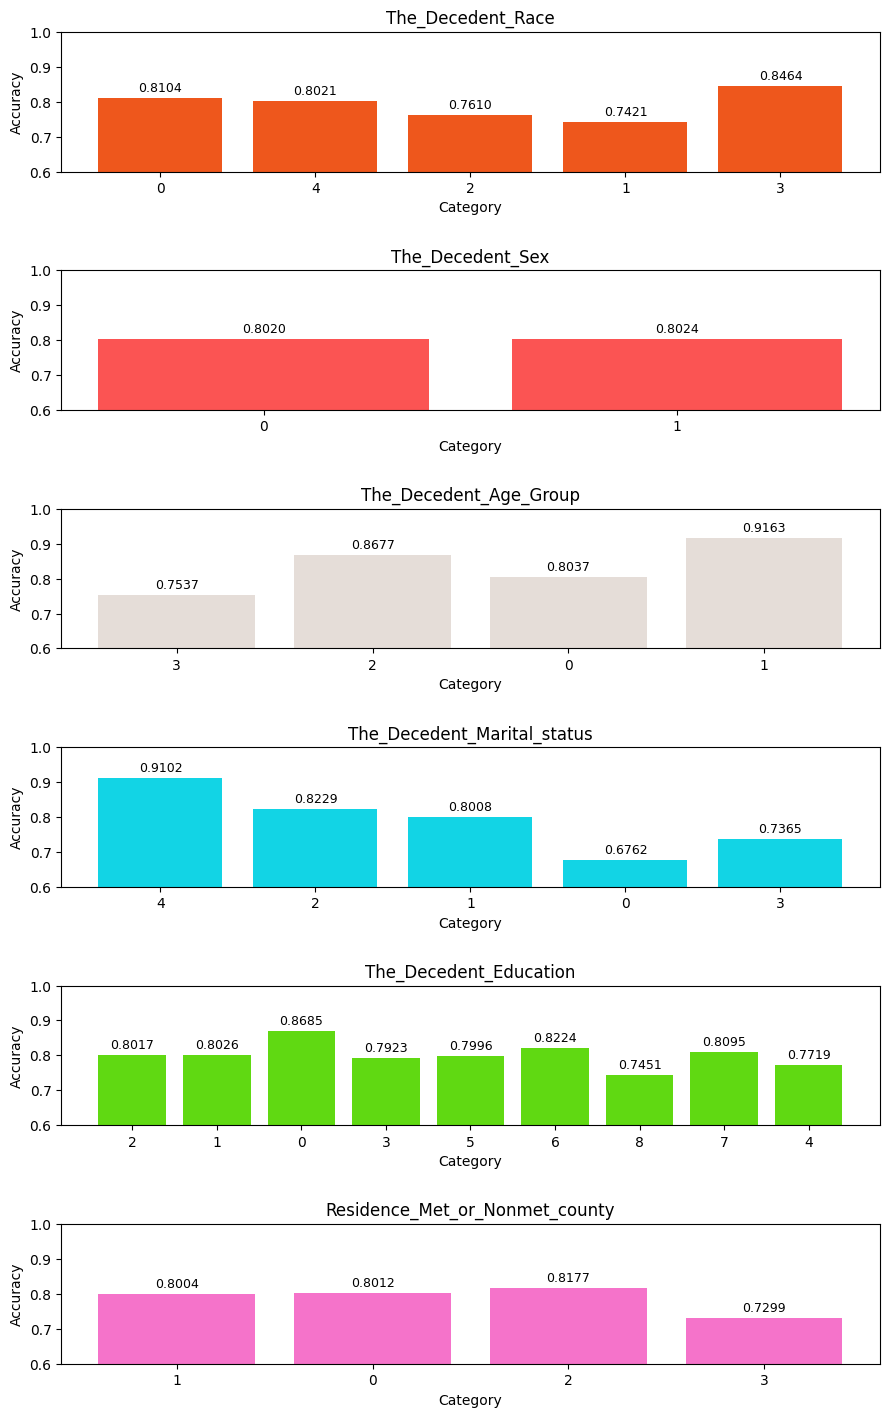

In [13]:
# Define the extracted performance data
categories = {
    'The_Decedent_Race': [('0', 0.8104), ('4', 0.8021), ('2', 0.7610), ('1', 0.7421), ('3', 0.8464)],
    'The_Decedent_Sex': [('0', 0.8020), ('1', 0.8024)],
    'The_Decedent_Age_Group': [('3', 0.7537), ('2', 0.8677), ('0', 0.8037), ('1', 0.9163)],
    'The_Decedent_Marital_status': [('4', 0.9102), ('2', 0.8229), ('1', 0.8008), ('0', 0.6762), ('3', 0.7365)],
    'The_Decedent_Education': [('2', 0.8017), ('1', 0.8026), ('0', 0.8685), ('3', 0.7923), ('5', 0.7996), 
                               ('6', 0.8224), ('8', 0.7451), ('7', 0.8095), ('4', 0.7719)],
    'Residence_Met_or_Nonmet_county': [('1', 0.8004), ('0', 0.8012), ('2', 0.8177), ('3', 0.7299)]
}

# Plot the data
fig, axs = plt.subplots(6, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for ax, (key, values) in zip(axs, categories.items()):
    labels, accuracies = zip(*values)
    ax.bar(labels, accuracies, color=np.random.rand(3,))
    ax.set_ylim([0.6, 1.0])
    ax.set_title(key)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Category')
    for i, v in enumerate(accuracies):
        ax.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=9)

plt.show()



# MixEffect for Linear

In [20]:
# Encode labels
train_x['Label'] = train_y
test_x['Label'] = test_y

combined = pd.concat([train_x, test_x], axis=0)

le_dict = {}

for col in combined.columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    le_dict[col] = le

# Split the datasets back, making sure to work with copies
train_x_encoded = combined.iloc[:len(train_x)].copy()
test_x_encoded = combined.iloc[len(train_x):].copy()

# Fix the dtype of 'Label' column
train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

# Define the formula for your mixed effects model
formula = 'Label ~ General_Data_year + The_Decedent_Sex + The_Decedent_Age_Group + The_Decedent_Race + The_Decedent_Marital_status + The_Decedent_Education + (1 | Residence_State_And_County)'

# Create a mixed effects model from your data
mixed_effect_model = smf.mixedlm(formula, data=train_x_encoded, groups=train_x_encoded['Residence_State_And_County'])

# Fit the model
mixed_effect_model_fit = mixed_effect_model.fit()

# Print the summary
print(mixed_effect_model_fit.summary())

# Predict the outcomes on the test set
test_df = test_x_encoded.copy()
test_df['predicted_values'] = mixed_effect_model_fit.predict(test_df)

# Convert predicted values to binary 0 or 1 based on threshold
test_df['predicted_binary'] = test_df['predicted_values'].apply(lambda x: 1 if x > 0.5 else 0)

# Calculate the metrics
accuracy = accuracy_score(test_df['Label'], test_df['predicted_binary'])
precision = precision_score(test_df['Label'], test_df['predicted_binary'])
recall = recall_score(test_df['Label'], test_df['predicted_binary'])
f1 = f1_score(test_df['Label'], test_df['predicted_binary'])
roc_auc = roc_auc_score(test_df['Label'], test_df['predicted_values']) # Use predicted_values for AUC
tn, fp, fn, tp = confusion_matrix(test_df['Label'], test_df['predicted_binary']).ravel()

print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      Label       
No. Observations:        753190       Method:                  REML        
No. Groups:              3134         Scale:                   0.1621      
Min. group size:         1            Log-Likelihood:          -385736.6188
Max. group size:         14329        Converged:               Yes         
Mean group size:         240.3                                             
---------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                       1.283    0.004  329.643 0.000  1.275  1.291
General_Data_year               0.010    0.000   59.373 0.000  0.009  0.010
The_Decedent_Sex                0.016    0.001   16.610 0.000  0.014  0.018
The_Decedent_Age_Group         

In [41]:
def run_mixed_effects_model(model, train_x, train_y, test_x, test_y):
    # Encode labels
    train_x = train_x.copy()
    test_x = test_x.copy()
    train_x['Label'] = train_y
    test_x['Label'] = test_y


    combined = pd.concat([train_x, test_x], axis=0)

    le_dict = {}

    for col in combined.columns:
        combined[col] = combined[col].astype(str)  # Convert all data to string type
        le = LabelEncoder()
        combined[col] = le.fit_transform(combined[col])
        le_dict[col] = le

    train_x_encoded = combined.iloc[:len(train_x)].copy()
    test_x_encoded = combined.iloc[len(train_x):].copy()

    train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

    formula = ('Label ~ General_Data_year + The_Decedent_Sex + The_Decedent_Age_Group + '
               'The_Decedent_Race + The_Decedent_Marital_status + The_Decedent_Education + '
               '(1 | Residence_State_And_County)')

    #mixed_effect_model = smf.mixedlm(formula, data=train_x_encoded, groups=train_x_encoded['Residence_State_And_County'])
    #mixed_effect_model_fit = mixed_effect_model.fit()
    
    mixed_effect_model = model
    
    #print(mixed_effect_model_fit.summary())

    test_df = test_x_encoded.copy()
    test_df['predicted_values'] = mixed_effect_model_fit.predict(test_df)
    test_df['predicted_binary'] = test_df['predicted_values'].apply(lambda x: 1 if x > 0.5 else 0)

    accuracy = accuracy_score(test_df['Label'], test_df['predicted_binary'])
    precision = precision_score(test_df['Label'], test_df['predicted_binary'])
    recall = recall_score(test_df['Label'], test_df['predicted_binary'])
    f1 = f1_score(test_df['Label'], test_df['predicted_binary'])
    roc_auc = roc_auc_score(test_df['Label'], test_df['predicted_values'])
    tn, fp, fn, tp = confusion_matrix(test_df['Label'], test_df['predicted_binary']).ravel()

    print(f'True Positives (TP): {tp}')
    print(f'False Positives (FP): {fp}')
    print(f'True Negatives (TN): {tn}')
    print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)
    
    return None



temp1 = run_mixed_effects_model(mixed_effect_model, train_x, train_y, test_x, test_y)

True Positives (TP): 113111
False Positives (FP): 22223
True Negatives (TN): 139174
False Negatives (FN): 48287
Accuracy: 0.7816
Precision: 0.8358
Recall: 0.7008
F1 Score: 0.7624
AUC-ROC: 0.8351
--------------------------------------------------


In [42]:
def evaluate_by_features_mix_effect_linear(model, train_x, train_y, test_x, test_y):
    features_to_evaluate = [
        'The_Decedent_Race', 
        'The_Decedent_Sex', 
        'The_Decedent_Age_Group', 
        'The_Decedent_Marital_status', 
        'The_Decedent_Education',
        'Residence_Met_or_Nonmet_county'
    ]

    for feature in features_to_evaluate:
        print(f"Evaluating based on {feature}...")
        
        unique_values = test_x[feature].unique()

        for value in unique_values:
            # Subset data for the specific feature value
            subset_test_x = test_x[test_x[feature] == value]
            subset_test_y = test_y[test_x[feature] == value]
            
            print(f"Performance for {feature} = {value}")
            
            # Evaluate the performance on the subset
            performance = run_mixed_effects_model(model, train_x, train_y, subset_test_x, subset_test_y)

            #print(f"Performance for {feature} = {value}: {performance}")

temp2 = evaluate_by_features_mix_effect_linear(mixed_effect_model, train_x, train_y, test_x, test_y)

Evaluating based on The_Decedent_Race...
Performance for The_Decedent_Race = 0
True Positives (TP): 90724
False Positives (FP): 16328
True Negatives (TN): 110856
False Negatives (FN): 35813
Accuracy: 0.7945
Precision: 0.8475
Recall: 0.7170
F1 Score: 0.7768
AUC-ROC: 0.8494
--------------------------------------------------
Performance for The_Decedent_Race = 4
True Positives (TP): 9555
False Positives (FP): 1800
True Negatives (TN): 8809
False Negatives (FN): 3818
Accuracy: 0.7657
Precision: 0.8415
Recall: 0.7145
F1 Score: 0.7728
AUC-ROC: 0.8117
--------------------------------------------------
Performance for The_Decedent_Race = 2
True Positives (TP): 1299
False Positives (FP): 266
True Negatives (TN): 771
False Negatives (FN): 447
Accuracy: 0.7438
Precision: 0.8300
Recall: 0.7440
F1 Score: 0.7847
AUC-ROC: 0.7839
--------------------------------------------------
Performance for The_Decedent_Race = 1
True Positives (TP): 10740
False Positives (FP): 3829
True Negatives (TN): 14847
Fals

True Positives (TP): 54
False Positives (FP): 22
True Negatives (TN): 69
False Negatives (FN): 66
Accuracy: 0.5829
Precision: 0.7105
Recall: 0.4500
F1 Score: 0.5510
AUC-ROC: 0.6539
--------------------------------------------------


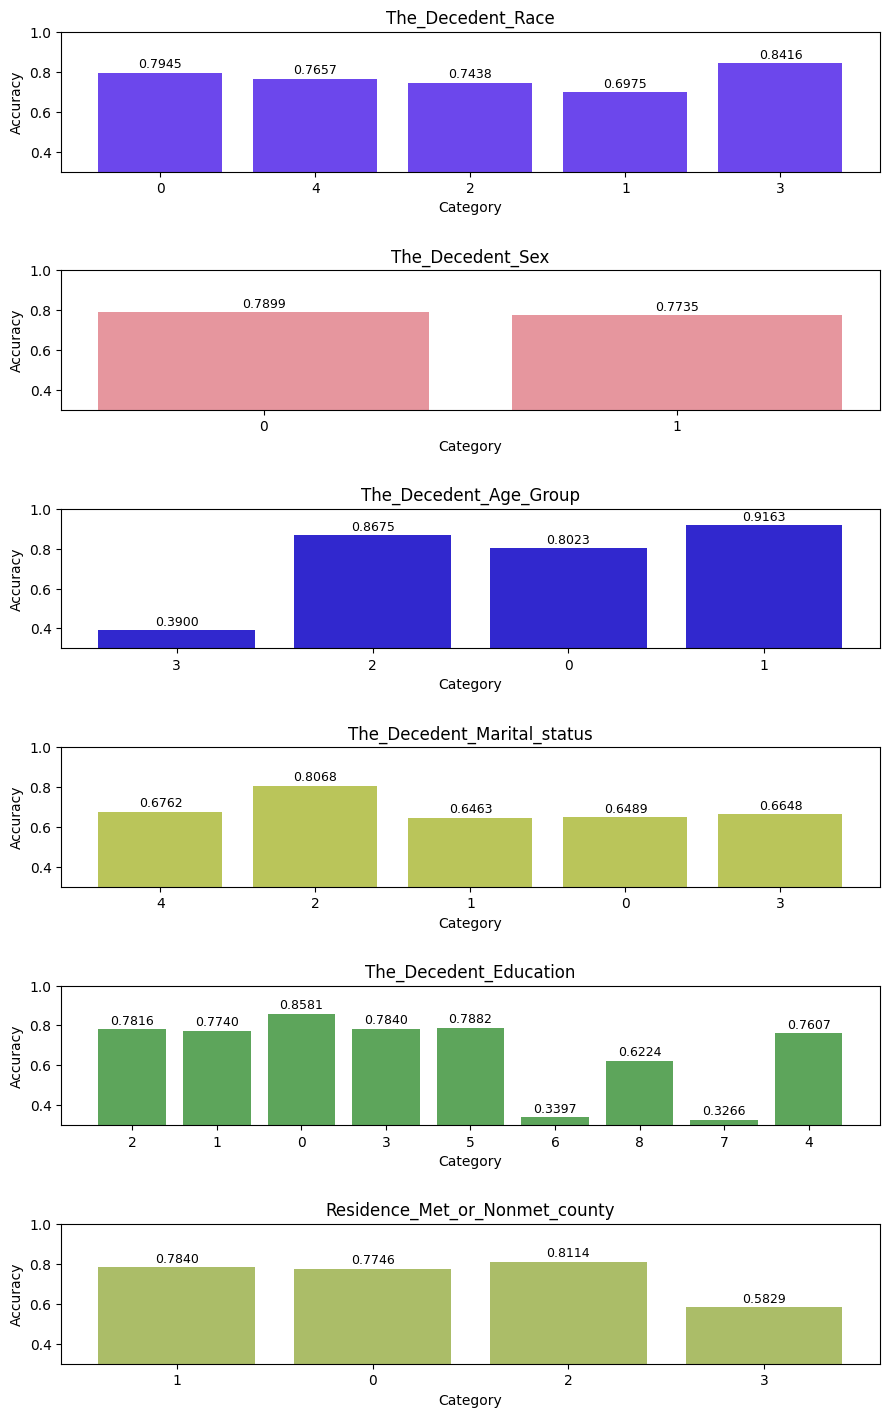

In [14]:
# Define the extracted performance data
categories = {
    'The_Decedent_Race': [('0', 0.7945), ('4', 0.7657), ('2', 0.7438), ('1', 0.6975), ('3', 0.8416)],
    'The_Decedent_Sex': [('0', 0.7899), ('1', 0.7735)],
    'The_Decedent_Age_Group': [('3', 0.3900), ('2', 0.8675), ('0', 0.8023), ('1', 0.9163)],
    'The_Decedent_Marital_status': [('4', 0.6762), ('2', 0.8068), ('1', 0.6463), ('0', 0.6489), ('3', 0.6648)],
    'The_Decedent_Education': [('2', 0.7816), ('1', 0.7740), ('0', 0.8581), ('3', 0.7840), ('5', 0.7882), 
                               ('6', 0.3397), ('8', 0.6224), ('7', 0.3266), ('4', 0.7607)],
    'Residence_Met_or_Nonmet_county': [('1', 0.7840), ('0', 0.7746), ('2', 0.8114), ('3', 0.5829)]
}

# Plot the data
fig, axs = plt.subplots(6, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for ax, (key, values) in zip(axs, categories.items()):
    labels, accuracies = zip(*values)
    ax.bar(labels, accuracies, color=np.random.rand(3,))
    ax.set_ylim([0.3, 1.0])  # updated y-limit for better visualization
    ax.set_title(key)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Category')
    for i, v in enumerate(accuracies):
        ax.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=9)

plt.show()

# AI 360

In [9]:
import aif360.datasets as datasets
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [13]:
# Ensure that all object type columns are encoded to numerical
le = LabelEncoder()
for column in train_x_encoded.select_dtypes(include=['object']).columns:
    train_x_encoded[column] = le.fit_transform(train_x_encoded[column])

# Store labels in a separate dataframe
train_labels = train_x_encoded['Label']

# Drop the 'Label' column
#train_x_encoded = train_x_encoded.drop(columns=['Label'])

# Convert dataframes to a BinaryLabelDataset format which is required by aif360
dataset_train = datasets.BinaryLabelDataset(favorable_label=1,
                                            unfavorable_label=0,
                                            df=train_x_encoded,
                                            label_names=['Label'],
                                            protected_attribute_names=['The_Decedent_Race'])


print(train_x_encoded["The_Decedent_Race"].value_counts())

privileged_groups = [{'The_Decedent_Race': 0}]
unprivileged_groups = [{'The_Decedent_Race': 1},
                       {'The_Decedent_Race': 2},
                       {'The_Decedent_Race': 3},
                       {'The_Decedent_Race': 4}]

# Compute fairness metric on original training dataset
metric_train = BinaryLabelDatasetMetric(dataset_train, 
                                        unprivileged_groups=unprivileged_groups, 
                                        privileged_groups=privileged_groups)
print("Mean difference (statistical parity difference) = %f" % metric_train.mean_difference())

# Bias mitigation
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_train)

# Check the fairness metric for the transformed dataset
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups, 
                                               privileged_groups=privileged_groups)
print("Transformed training dataset mean difference = %f" % metric_transf_train.mean_difference())



# Convert the 'Residence_State' column to category type
train_x['Residence_State_And_County'] = train_x['Residence_State_And_County'].astype('category')
test_x['Residence_State_And_County'] = test_x['Residence_State_And_County'].astype('category')

# Convert the category labels to codes
train_x['Residence_State_And_County'] = train_x['Residence_State_And_County'].cat.codes
test_x['Residence_State_And_County'] = test_x['Residence_State_And_County'].cat.codes

train_and_evaluate_xgb_model(train_x, train_y, test_x, test_y)


KeyError: 'Label'